Clean my GPU memory cache

And try to use my GPU device for following experiments


In [113]:
import torch

torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Load my self-made alphabet image dataset.

Check the file `gen-char-image.ipynb` to see details of how I created the dataset.


Input shape: torch.Size([8, 1, 32, 32])
Labels: tensor([1, 2, 7, 2, 0, 7, 7, 6])


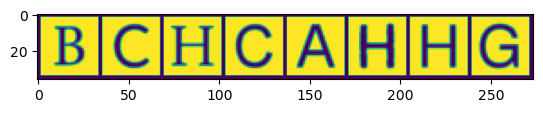

In [114]:
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

#
dataset = torchvision.datasets.ImageFolder(
    './data/char', transform=transform)

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_loader))
image_size = x.shape[2]
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0])

Define a `add_noise` function to add noise to the image

The `percent` parameter indicates how much noise we want to pollute the image,

- `1` is totally(100%) noise,
- and `0` is totally the original image.


x shape: torch.Size([8, 1, 32, 32])
percent: tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])
noised_x shape: torch.Size([8, 1, 32, 32])


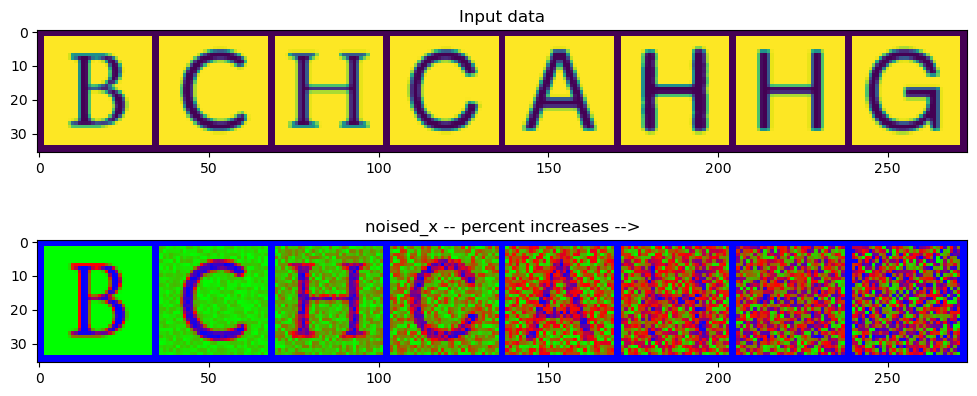

In [115]:
def add_noise(x, percent):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    percent = percent.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x*(1-percent) + noise*percent


# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
print('x shape:', x.shape)
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0])

# Pollute
percent = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
print('percent:', percent)
noised_x = add_noise(x, percent)
print('noised_x shape:', noised_x.shape)

# Plotting the polluted version
axs[1].set_title('noised_x -- percent increases -->')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='brg')

Let's create a simple UNet model

![image](https://user-images.githubusercontent.com/11864008/233883443-0a04ba0e-7bf6-4a8d-ac5a-fc0169e6c17b.png)


In [116]:
from torch import nn


class SimpleUNet(nn.Module):
    """A simple UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv_4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv_5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv_6 = nn.Conv2d(32, out_channels, kernel_size=3, padding=1)

        self.act = nn.ReLU(inplace=True)
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        conv1 = self.act(self.conv_1(x))
        x = self.downscale(conv1)

        conv2 = self.act(self.conv_2(x))
        x = self.downscale(conv2)

        x = self.act(self.conv_3(x))

        x = self.act(self.conv_4(x))

        x = self.upscale(x)
        x = self.act(self.conv_5(x+conv2))

        x = self.upscale(x)
        x = self.act(self.conv_6(x+conv1))

        return x

Test if I did the shape transforms correctly:


In [117]:
net1 = SimpleUNet(1, 1)
x1 = torch.rand([8, 1, image_size, image_size])
net1(x1).shape

torch.Size([8, 1, 32, 32])

See how many parameters of the UNet model.


In [118]:
sum([p.numel() for p in net1.parameters()])

111425

Finished epoch 01, loss: 0.309984
Finished epoch 02, loss: 0.122827
Finished epoch 03, loss: 0.085746
Finished epoch 04, loss: 0.062330
Finished epoch 05, loss: 0.053144
Finished epoch 06, loss: 0.043270
Finished epoch 07, loss: 0.037776
Finished epoch 08, loss: 0.037905
Finished epoch 09, loss: 0.035040
Finished epoch 10, loss: 0.031915
Finished epoch 11, loss: 0.031549
Finished epoch 12, loss: 0.034112
Finished epoch 13, loss: 0.034822
Finished epoch 14, loss: 0.029968
Finished epoch 15, loss: 0.028342
Finished epoch 16, loss: 0.027482
Finished epoch 17, loss: 0.028382
Finished epoch 18, loss: 0.027169
Finished epoch 19, loss: 0.026430
Finished epoch 20, loss: 0.026736
Finished epoch 21, loss: 0.030284
Finished epoch 22, loss: 0.020722
Finished epoch 23, loss: 0.020148
Finished epoch 24, loss: 0.021724
Finished epoch 25, loss: 0.025852
Finished epoch 26, loss: 0.025399
Finished epoch 27, loss: 0.024979
Finished epoch 28, loss: 0.020603
Finished epoch 29, loss: 0.023306
Finished epoch

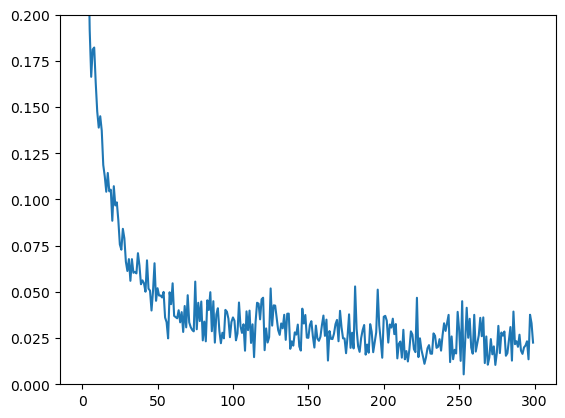

In [119]:

def train1(net: nn.Module, n_epochs=50):

    # How many runs through the data should we do?
    # n_epochs = 100

    # Create the network
    # net = SimpleUNet(1, 1)
    net.to(device)

    # Our loss function
    loss_fn = nn.MSELoss()

    # The optimizer
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)

    # Keeping a record of the losses for later viewing
    losses = []

    # The training loop
    for epoch in range(1, n_epochs+1):

        for x, y in train_loader:

            # Get some data and prepare the corrupted version
            x = x.to(device)  # Data on the GPU

            # Pick random noise amounts
            noise_amount = torch.rand(x.shape[0]).to(device)
            # noise_amount = torch.full([x.shape[0]], 1/n_epochs).to(device)
            noisy_x = add_noise(x, noise_amount)  # Create our noisy x

            # Get the model prediction
            pred = net(noisy_x)

            # Calculate the loss
            # How close is the output to the true 'clean' x?
            loss = loss_fn(pred, x)

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
        print(f'Finished epoch {epoch:0>2}, loss: {avg_loss:05f}')

    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.2)


net1 = SimpleUNet(1, 1)
x1 = torch.rand([8, 1, image_size, image_size])
net1(x1).shape


train1(net1, 30)

Let see how good the model predictions look like:


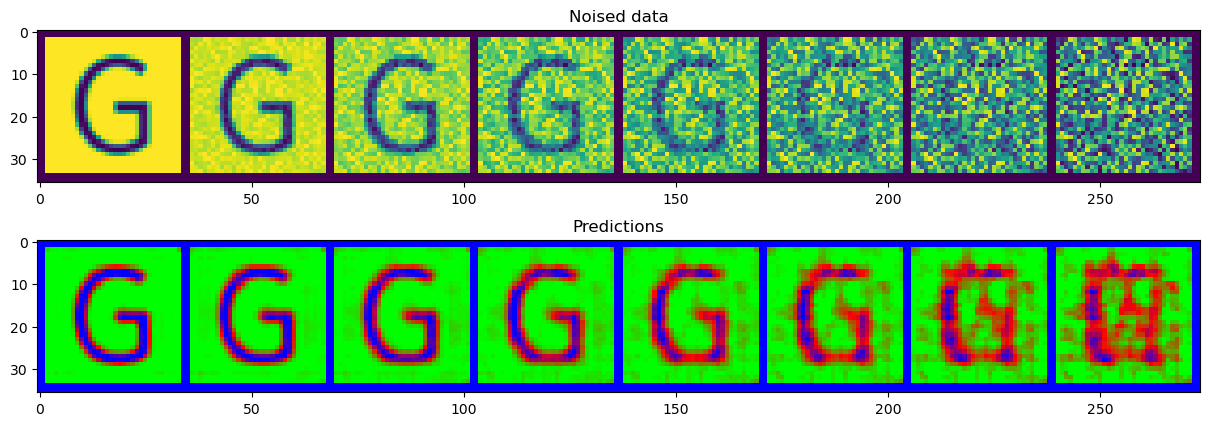

In [120]:

def test_simple_unet(net: nn.Module):
    # Fetch some data
    x, y = next(iter(train_loader))
    x = x[0]  # Use the first image of the first batch

    # Corrupt with a range of amounts
    amount = torch.linspace(0, 1, 8)  # Left to right -> more corruption
    noised_x = add_noise(x, amount)

    # Get the model predictions
    with torch.no_grad():
        preds = net(noised_x.to(device)).detach().cpu()

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(15, 5))
    axs[0].set_title('Noised data')
    axs[0].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1))
    axs[1].set_title('Predictions')
    axs[1].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='brg')


test_simple_unet(net1)

The model predicts good if the percent of noise is low!

But predicts bad if the percentage of noise is high!

Let's try to improve this.


What will it look like if we repeat the prediction more times, try 10 times?

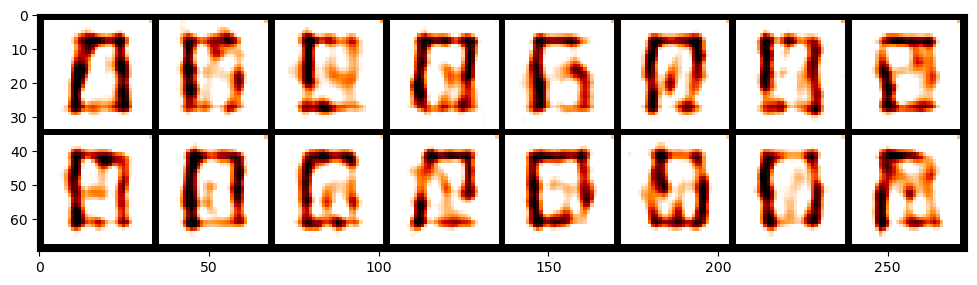

In [121]:
n_times = 3
x = torch.rand(16, 1, image_size, image_size).to(device)  # Start from random

with torch.no_grad():  # No need to track gradients during inference
    for i in range(n_times):
        x = net1(x)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(
    x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='gist_heat')

Not good.

What will it look like if we split the prediction to small steps and repeat the prediction?



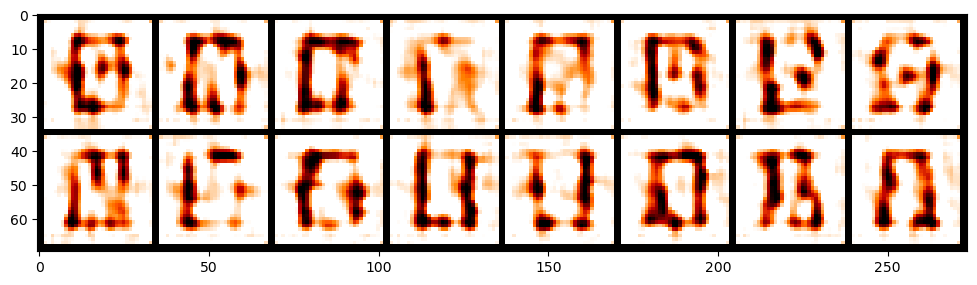

In [122]:
n_steps = 10
x = torch.rand(16, 1, image_size, image_size).to(device)

with torch.no_grad():
    for i in range(n_steps):
        pred = net1(x)
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(
    x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='gist_heat')

Still not good.



Let's try UNet with attention blocks, using the diffusers lib.

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

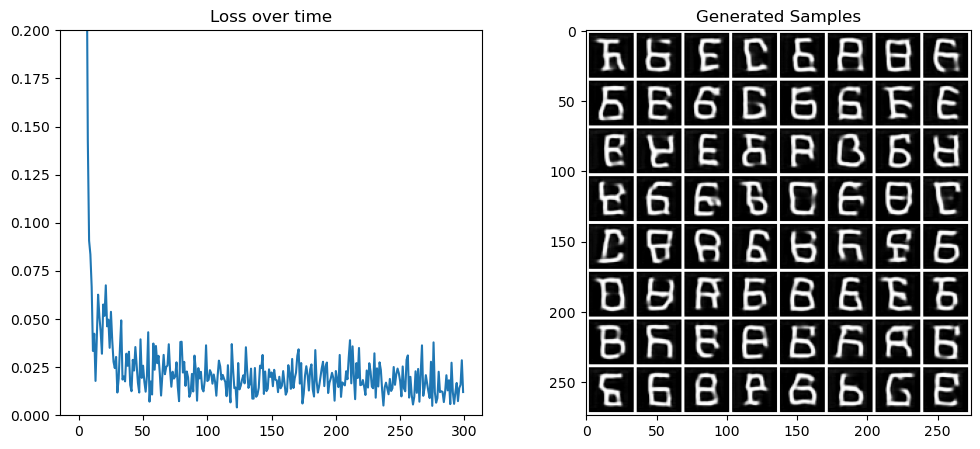

In [123]:
from diffusers import UNet2DModel


def train2(net: UNet2DModel,  n_epochs=50):

    # How many runs through the data should we do?
    # n_epochs = 50

    # Create the network
    # net = SimpleUNet(1, 1)
    net.to(device)

    # Our loss function
    loss_fn = nn.MSELoss()

    # The optimizer
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)

    # Keeping a record of the losses for later viewing
    losses = []

    # The training loop
    for epoch in range(1, n_epochs+1):

        for x, y in train_loader:

            # Get some data and prepare the corrupted version
            x = x.to(device)  # Data on the GPU

            # Pick random noise amounts
            noise_amount = torch.rand(x.shape[0]).to(device)
            noisy_x = add_noise(x, noise_amount)  # Create our noisy x
            # Get the model prediction
            pred = net(noisy_x, 1000).sample

            # Calculate the loss
            # How close is the output to the true 'clean' x?
            loss = loss_fn(pred, x)

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
        print(f'Finished epoch {epoch:0>2}, loss: {avg_loss:05f}')

    # Plot losses and some samples
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Losses
    axs[0].plot(losses)
    axs[0].set_ylim(0, 0.2)
    axs[0].set_title('Loss over time')

    # Samples
    n_steps = 10
    x = torch.rand(64, 1, image_size, image_size).to(device)
    for i in range(n_steps):
        with torch.no_grad():
            pred = net(x, 0).sample
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor

    axs[1].imshow(torchvision.utils.make_grid(
        x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
    axs[1].set_title('Generated Samples')


# Create the network
net2 = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
    ),
)

# See the model blocks
print(net2)

train2(net2, 30)

Text(0.5, 1.0, 'net2 Generated Samples')

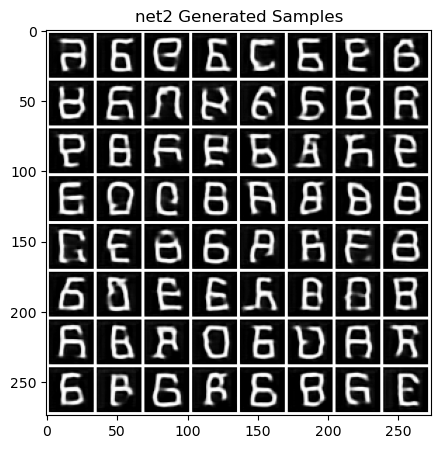

In [124]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

# Samples
n_steps = 10
samples = torch.rand(64, 1, image_size, image_size).to(device)
for i in range(n_steps):
    with torch.no_grad():
        pred = net2(samples, 0).sample
    mix_factor = 1/(n_steps - i)
    samples = samples*(1-mix_factor) + pred*mix_factor

axs.imshow(torchvision.utils.make_grid(
    samples.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs.set_title('net2 Generated Samples')

The generated images are clear than before.

But, still not good enough!


Is it any problem from the dataset?

Let me try to generate alphabet images with only one font type, and run these code again.



Still not good, let me try to add more blocks and layers


ClassConditionedUnet(
  (class_emb): Embedding(8, 4)
  (model): UNet2DModel(
    (conv_in): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
   

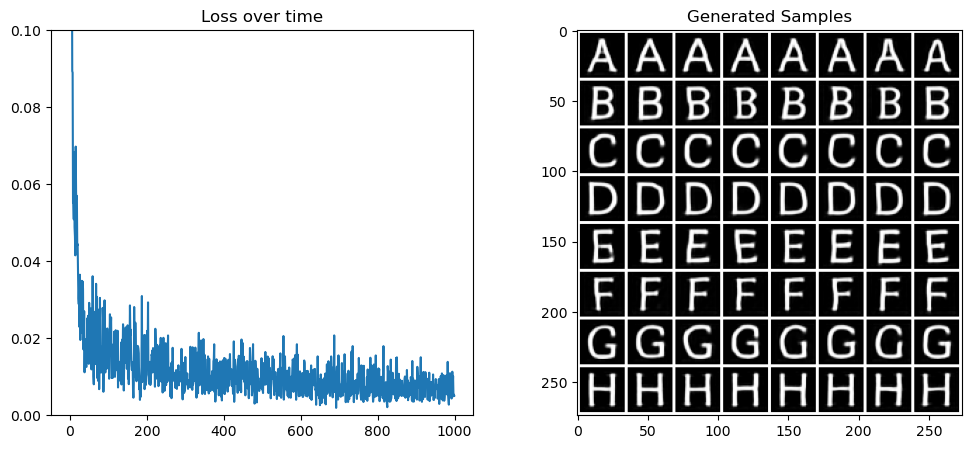

In [160]:
# UNet2DModel with class embedding

class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=8, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=32,
            in_channels=1+class_emb_size,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 128, 256),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = self.class_emb(class_labels)  # Map to embedding dinemsion
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(
            bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 5, 28, 28)

        # Feed this to the unet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)


def train3(net: UNet2DModel,  n_epochs=50):

    # How many runs through the data should we do?
    # n_epochs = 50

    # Create the network
    # net = SimpleUNet(1, 1)
    net.to(device)

    # Our loss function
    loss_fn = nn.MSELoss()

    # The optimizer
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)

    # Keeping a record of the losses for later viewing
    losses = []

    # The training loop
    for epoch in range(1, n_epochs+1):

        for x, y in train_loader:

            # Get some data and prepare the corrupted version
            x = x.to(device)  # Data on the GPU
            y = y.to(device)

            # Pick random noise amounts
            noise_amount = torch.rand(x.shape[0]).to(device)
            noisy_x = add_noise(x, noise_amount)  # Create our noisy x
            # Get the model prediction
            pred = net(noisy_x, 1000,   y)

            # Calculate the loss
            # How close is the output to the true 'clean' x?
            loss = loss_fn(pred, x)

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
        print(f'Finished epoch {epoch:0>2}, loss: {avg_loss:05f}')

    # Plot losses and some samples
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Losses
    axs[0].plot(losses)
    axs[0].set_ylim(0, 0.1)
    axs[0].set_title('Loss over time')

    # Samples
    n_steps = 10
    # Prepare random x to start from, plus some desired labels y
    tx = torch.rand(64, 1, image_size, image_size).to(device)
    ty = torch.tensor([[i]*8 for i in range(8)]).flatten().to(device)

    # Sampling loop
    for i in range(n_steps):

        # Get model pred
        with torch.no_grad():
            pred = net(tx, 0, ty)  # Again, note that we pass in our labels y

        # Update sample with step
        mix_factor = 1/(n_steps - i)
        tx = tx*(1-mix_factor) + pred*mix_factor

    axs[1].imshow(torchvision.utils.make_grid(
        tx.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
    axs[1].set_title('Generated Samples')


# Create the network
net3 = ClassConditionedUnet()

# See the model blocks
print(net3)

train3(net3, 100)

Text(0.5, 1.0, 'net3 Generated Samples')

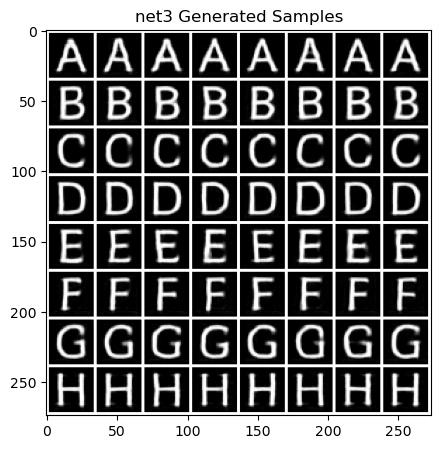

In [161]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 1, figsize=(12, 5))

# Samples
n_steps = 2
# Prepare random x to start from, plus some desired labels y
tx = torch.rand(64, 1, image_size, image_size).to(device)
ty = torch.tensor([[i]*8 for i in range(8)]).flatten().to(device)

# Sampling loop
for i in range(n_steps):

    # Get model pred
    with torch.no_grad():
        pred = net3(tx, 0, ty)  # Again, note that we pass in our labels y

    # Update sample with step
    mix_factor = 1/(n_steps - i)
    tx = tx*(1-mix_factor) + pred*mix_factor

axs.imshow(torchvision.utils.make_grid(
    tx.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs.set_title('net3 Generated Samples')